[Hierarchical Time Series Using PyMC](https://charlescopley.medium.com/heirarchical-time-series-using-pymc-29acd6a7c401)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# Simulating some data
np.random.seed(0)

n_groups      = 3  # number of groups
n_data_points = 100  # number of data points per group

x               = np.tile(np.linspace(0, 10, n_data_points), n_groups)
group_indicator = np.repeat(np.arange(n_groups), n_data_points)
slope_true      = np.random.normal(0, 1, size=n_groups)
intercept_true  = np.random.normal(2, 1, size=n_groups)

y = slope_true[group_indicator]*x + intercept_true[group_indicator] + np.random.normal(0, 1, size=n_groups*n_data_points)


In [2]:
x.shape

(300,)

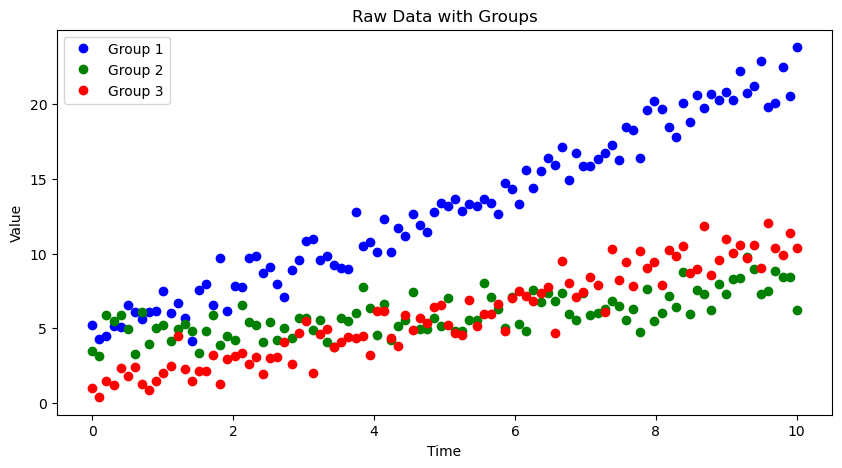

In [3]:
colors = ['b', 'g', 'r']  # Define different colors for each group

plt.figure(figsize=(10, 5))

# Plot raw data for each group
for i in range(n_groups):
    plt.plot(x[group_indicator == i], y[group_indicator == i], 'o', color=colors[i], label=f'Group {i+1}')

plt.title('Raw Data with Groups')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [4]:
hierarchical_model = pm.Model()

with hierarchical_model:
    # Hyperpriors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=10)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=10)
  
    # Priors
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_groups)  # group-specific intercepts
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_groups)  # group-specific slopes
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value
    mu = alpha[group_indicator] + beta[group_indicator] * x

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

In [8]:
with hierarchical_model:
    # Sampling
    trace = pm.sample(2000, tune=1000, nuts_sampler = "numpyro")

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.356477
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3000 [00:10<?, ?it/s]


Running chain 0:   5%|▌         | 150/3000 [00:10<00:02, 1215.35it/s]


Running chain 0:  25%|██▌       | 750/3000 [00:10<00:00, 3678.35it/s]


Running chain 0:  45%|████▌     | 1350/3000 [00:10<00:00, 4537.90it/s]


Running chain 0:  65%|██████▌   | 1950/3000 [00:10<00:00, 4824.27it/s]


Running chain 0:  85%|████████▌ | 2550/3000 [00:10<00:00, 4257.69it/s]







Running chain 3: 100%|██████████| 3000/3000 [00:10<00:00, 273.32it/s] 


Sampling time =  0:00:11.846984
Transforming variables...
Transformation time =  0:00:00.026275


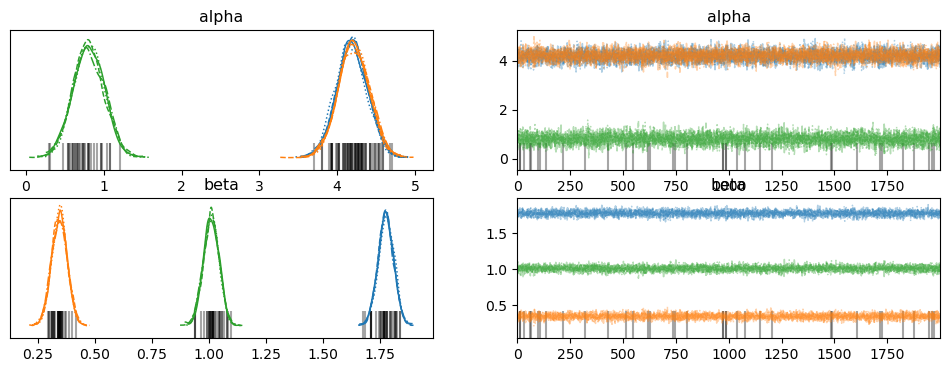

In [6]:
# Checking the trace
pm.plot_trace(trace,var_names=['alpha','beta'])
plt.show()

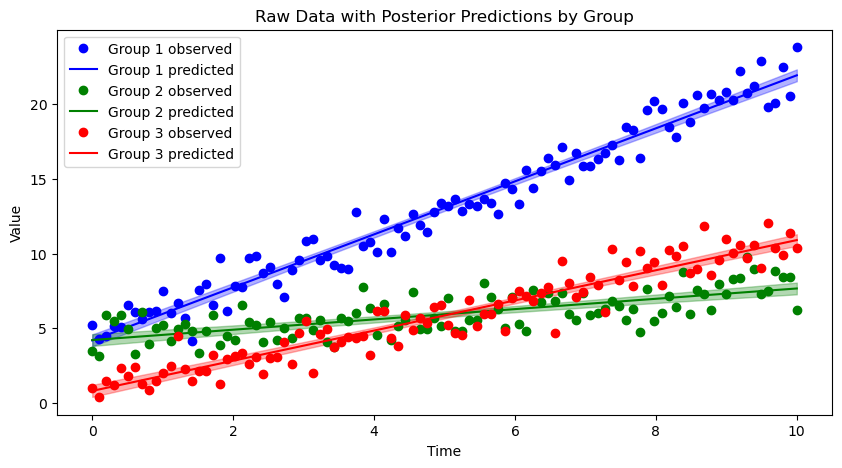

In [7]:
# Posterior samples
alpha_samples = trace.posterior['alpha'].values
beta_samples = trace.posterior['beta'].values

# New x values for predictions
x_new = np.linspace(0, 10, 200)

plt.figure(figsize=(10, 5))

# Plot raw data and predictions for each group
for i in range(n_groups):
    # Plot raw data
    
    plt.plot(x[group_indicator == i], y[group_indicator == i], 'o', color=colors[i], label=f'Group {i+1} observed')
    x_new = x[group_indicator == i]
    # Generate and plot predictions
    alpha = trace.posterior.sel(alpha_dim_0=i,beta_dim_0=i)['alpha'].values
    beta = trace.posterior.sel(alpha_dim_0=i,beta_dim_0=i)['beta'].values
    y_hat = alpha[..., None] + beta[..., None] * x_new[None,:]
    y_hat_mean = y_hat.mean(axis=(0, 1))
    y_hat_std = y_hat.std(axis=(0, 1))
    plt.plot(x_new, y_hat_mean, color=colors[i], label=f'Group {i+1} predicted')
    plt.fill_between(x_new, y_hat_mean - 2*y_hat_std, y_hat_mean + 2*y_hat_std, color=colors[i], alpha=0.3)

plt.title('Raw Data with Posterior Predictions by Group')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# EXAMPLE 2
https://cluhmann.github.io/inferencedata/

In [3]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import matplotlib.pyplot as plt

rng = np.random.default_rng(101010)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [5]:
group_size = 100
systolic_f = rng.normal(loc=123, scale=5, size=group_size)
systolic_m = rng.normal(loc=127, scale=5, size=group_size)
systolic = np.hstack((systolic_f, systolic_m))
sex = (['female'] * group_size) + (['male'] * group_size)
age = rng.normal(loc=50, scale=7, size=len(systolic))
treat_group = rng.integers(low=1, high=3, size=len(systolic))
patient_id = rng.choice(1000, size=len(systolic), replace=False)
systolic = systolic + (.05 * age)
df = pd.DataFrame({'bp':systolic,
                   'sex':sex,
                   'age':age,
                   'treat_group':treat_group})
df.index = patient_id
df.index.name = "patientID"
df.head()

,bp,sex,age,treat_group
patientID,,,,
704,120.942134,female,50.254782,1
351,124.089759,female,54.197288,1
830,132.103747,female,52.909335,1
884,128.069846,female,49.068940,1
515,130.400603,female,52.303176,2


In [6]:
seed: int = sum(map(ord, "multilevel_elasticities_single_sku"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [7]:
sex_idx,sex_codes = pd.factorize(df["sex"])

coords = {'sex':['female','male']}

In [8]:
with pm.Model(coords=coords) as labeled_model:
    # hyper prior
    mu_hyper = pm.Normal('mu_hyper', mu=120, sigma=15)
    # per-group prior
    mu = pm.Normal('mu', mu=mu_hyper, sigma=15, dims='sex')
    # likelihood
    likelihood = pm.Normal('likelihood', 
                           mu=mu[sex_idx],
                           sigma=15, 
                           observed=df['bp'])

In [9]:
with labeled_model:
    labeled_idata = pm.sample(nuts_sampler='numpyro')

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling...
Compilation time = 0:00:13.888052
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:11<?, ?it/s]


Running chain 0:  60%|██████    | 1200/2000 [00:11<00:00, 11848.54it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:11<00:00, 173.61it/s]
Sampling time = 0:00:12.913826
Transforming variables...
Transformation time = 0:00:00.584714


In [10]:
az.summary(labeled_idata, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
mu_hyper,124.77,8.80,108.23,141.39
mu[female],125.22,1.48,122.52,128.10
mu[male],129.70,1.48,126.95,132.41


In [11]:
# average over chains and draws
labeled_idata.posterior['mu'].mean(dim=['chain', 'draw'])

<xarray.DataArray 'mu' (sex: 2)>
array([125.22153074, 129.70437115])
Coordinates:
  * sex      (sex) <U6 'female' 'male'

In [12]:
labeled_idata.posterior['mu'].sel(sex='female').mean()

<xarray.DataArray 'mu' ()>
array(125.22153074)
Coordinates:
    sex      <U6 'female'

In [13]:
labeled_idata.posterior['mu'].sel(sex='male').mean()

<xarray.DataArray 'mu' ()>
array(129.70437115)
Coordinates:
    sex      <U6 'male'

In [14]:
( labeled_idata.posterior['mu'].sel(sex='female') <
  labeled_idata.posterior['mu'].sel(sex='male') ).mean()

<xarray.DataArray 'mu' ()>
array(0.985)

## pm.Data

In [15]:
with pm.Model() as model:

    # define our one parameter
    coef = pm.Normal('coef', mu=0, sigma=15)

    # our data is used here...
    mean = coef * df['age'].to_numpy()

    # ...and also here, as our observed data
    # likelihood
    likelihood = pm.Normal('likelihood', 
                           mu=mean,
                           sigma=15, 
                           observed=df['bp'].to_numpy())
    idata = pm.sample(nuts_sampler='numpyro')

Compiling...
Compilation time = 0:00:06.148420
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:05<00:00, 347.05it/s]
Sampling time = 0:00:06.009083
Transforming variables...
Transformation time = 0:00:00.108639


In [16]:
idata.groups

<bound method InferenceData.groups of Inference data with groups:
	> posterior
	> sample_stats
	> observed_data>

In [17]:
coords = {'patient_id':df.index}
with pm.Model(coords=coords) as model:
    
    # here we define pm.Data objects so that PyMC is aware
    # of our model-relevant data
    age =           pm.MutableData('age', df['age'], dims='patient_id')
    bloodpressure = pm.MutableData('bloodpressure', df['bp'], dims='patient_id')

    # define our one parameter
    coef = pm.Normal('coef', mu=0, sigma=15)

    # our data is still used here...
    mean = coef * age

    # ...and here, as our observed data
    # likelihood
    likelihood = pm.Normal('likelihood', 
                           mu=mean,
                           sigma=15, 
                           observed=bloodpressure)
    idata = pm.sample(nuts_sampler='numpyro')

Compiling...
Compilation time = 0:00:01.881080
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:05<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:05<00:00, 340.26it/s]
Sampling time = 0:00:06.170294
Transforming variables...
Transformation time = 0:00:00.098748


In [18]:
idata.groups

<bound method InferenceData.groups of Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data>

In [23]:
sex_idx, sex_codes = pd.factorize(df["sex"])

coords = {'sex': ['female','male']}

with pm.Model(coords=coords) as labeled_model:
    # hyper prior
    mu_hyper = pm.Normal('mu_hyper', mu=120, sigma=15)
    # per-group prior
    mu = pm.Normal('mu', mu=mu_hyper, sigma=15, dims='sex')
    # likelihood
    likelihood = pm.Normal('likelihood', 
                           mu=mu[sex_idx],
                           sigma=15, 
                           observed=df['bp'])

In [24]:
sex_codes

Index(['female', 'male'], dtype='object')

In [29]:
sex_idx, sex_codes = pd.factorize(df["sex"])
n = df.shape[0]

coords = {'sex': ['female','male'],
          'patient_id': df.index}
with pm.Model(coords=coords) as model:
    
    # here we define pm.Data objects so that PyMC is aware
    # of our model-relevant data
    age           = pm.MutableData('age', df['age'], dims='patient_id')
    bloodpressure = pm.MutableData('bloodpressure', df['bp'], dims='patient_id')

    # hyper prior
    coef_hyper = pm.Normal('coef_hyper', mu=0, sigma=15)

    # per-group - define our one parameter
    coef = pm.Normal('coef', mu=coef_hyper, sigma=15, dims='sex')

    # our data is still used here...
    # mean = coef[sex_idx] * age # Con pymc < 9.0 hay que hacer esto si se usa nuts_sampler = 'numpyro'
    mu = pm.Deterministic("mu", coef[sex_idx] * age, dims='patient_id') 
    
    # ...and here, as our observed data
    # likelihood
    likelihood = pm.Normal('likelihood', 
                           mu=mu,
                           sigma=15, 
                           observed=bloodpressure, dims='patient_id')

In [30]:
with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=6_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )

Compiling...
Compilation time = 0:00:01.789664
Sampling...
Compiling.. :   0%|          | 0/7000 [00:00<?, ?it/s]

















Running chain 0:   0%|          | 0/7000 [00:07<?, ?it/s]


Running chain 0:   5%|▌         | 350/7000 [00:07<00:02, 3195.20it/s]








Running chain 0:  50%|█████     | 3500/7000 [00:07<00:00, 16910.21it/s]




Running chain 0:  70%|███████   | 4900/7000 [00:07<00:00, 14979.77it/s]

Running chain 0:  95%|█████████▌| 6650/7000 [00:07<00:00, 15468.67it/s]


Running chain 4: 100%|██████████| 7000/7000 [00:07<00:00, 897.91it/s]  
Sampling time = 0:00:08.047652
Transforming variables...
Transformation time = 0:00:00.404959
Computing Log Likelihood...
Log Likelihood time = 0:00:01.014788


In [31]:
az.summary(idata, kind="all", round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coef_hyper,1.70,8.74,-15.11,17.79,0.05,0.05,27465.72,21280.04,1.0
coef[female],2.46,0.03,2.40,2.51,0.00,0.00,26888.71,21990.86,1.0
coef[male],2.56,0.03,2.50,2.61,0.00,0.00,28803.40,22921.00,1.0
mu[704],123.41,1.51,120.63,126.28,0.01,0.01,26888.71,21990.86,1.0
mu[351],133.09,1.63,130.09,136.19,0.01,0.01,26888.71,21990.86,1.0
...,...,...,...,...,...,...,...,...,...
mu[368],155.56,1.80,152.20,158.94,0.01,0.01,28803.40,22921.00,1.0
mu[856],84.66,0.98,82.83,86.50,0.01,0.00,28803.40,22921.00,1.0
mu[145],145.66,1.69,142.51,148.82,0.01,0.01,28803.40,22921.00,1.0
mu[468],123.32,1.43,120.65,126.00,0.01,0.01,28803.40,22921.00,1.0


## Más general y con 2 grupos transversales

In [12]:
df['treat_group'].unique()

array([1, 2], dtype=int64)

In [26]:
sex_idx, sex_codes = pd.factorize(df["sex"])
treatment_idx, treatment_codes = pd.factorize(df["treat_group"])

pred_vars = ['age']

coords = {'sex': ['female','male'],
          'treat_group': ['1','2'],
          'patient_id': df.index}
with pm.Model(coords=coords) as model:
    
    # here we define pm.Data objects so that PyMC is aware
    # of our model-relevant data
    age           = pm.MutableData('age', df['age'], dims='patient_id')
    bloodpressure = pm.MutableData('bloodpressure', df['bp'], dims='patient_id')
    treat_group   = pm.MutableData('treat_group', df['treat_group'], dims='patient_id')

    # hyper priors
    coef_sex_prior = {}
    for pred_var in pred_vars:
        coef_sex_prior[pred_var] = pm.Normal(f'coef_sex_prior_{pred_var}', mu=0, sigma=15)
    coef_treatment_prior = {}
    for pred_var in pred_vars:
        coef_treatment_prior[pred_var] = pm.Normal(f'coef_treatment_prior_{pred_var}', mu=0, sigma=15)

    # per-group - define our parameters
    coef_sex = {}
    coef_treatment = {}
    for pred_var in pred_vars:
        coef_sex[pred_var] = pm.Normal(f'coef_sex_{pred_var}', mu = coef_sex_prior[pred_var], sigma = 15, dims = 'sex')
        coef_treatment[pred_var] = pm.Normal(f'coef_treatment_{pred_var}', mu = coef_treatment_prior[pred_var], sigma = 15, dims = 'treat_group')

    # our data is still used here...
    mu = 0
    for pred_var in pred_vars:
        mu += coef_sex[pred_var][sex_idx] * age + coef_treatment[pred_var][treatment_idx] * age
    mu = pm.Deterministic("mu", mu, dims='patient_id') 
    
    # ...and here, as our observed data
    # likelihood
    likelihood = pm.Normal('y', 
                           mu=mu,
                           sigma=15, 
                           observed=bloodpressure, dims='patient_id')

In [27]:
with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=6000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )

Compiling...
Compilation time = 0:00:02.645160
Sampling...
Compiling.. :   0%|          | 0/7000 [00:00<?, ?it/s]
















Running chain 0:   0%|          | 0/7000 [00:08<?, ?it/s]






Running chain 0:   5%|▌         | 350/7000 [00:10<00:36, 182.49it/s]


Running chain 0:  10%|█         | 700/7000 [00:11<00:33, 189.52it/s]





Running chain 0:  15%|█▌        | 1050/7000 [00:14<00:34, 171.39it/s]





Running chain 0:  20%|██        | 1400/7000 [00:17<00:38, 147.15it/s]





Running chain 0:  25%|██▌       | 1750/7000 [00:19<00:34, 151.41it/s]





Running chain 0:  30%|███       | 2100/7000 [00:22<00:34, 142.94it/s]





Running chain 0:  35%|███▌      | 2450/7000 [00:24<00:31, 144.62it/s]








Running chain 0:  40%|████      | 2800/7000 [00:26<00:29, 141.96it/s]


Running chain 0:  45%|████▌     | 3150/7000 [00:28<00:25, 152.07it/s]








Running chain 0:  50%|█████     | 3500/7000 [00:31<00:22, 154.50it/s]








Running chain 0:  55%|█████▌    | 3850/7000 [00:33<00:2

In [31]:
az.summary(idata, var_names = "^coef", filter_vars = 'regex', kind="all", round_to=2, )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coef_sex_prior_age,0.05,12.24,-21.93,23.55,0.35,0.25,1244.46,2873.97,1.00
coef_treatment_prior_age,1.75,12.39,-21.62,24.92,0.35,0.25,1236.11,2904.92,1.00
coef_sex_age[female],0.01,13.14,-25.08,24.31,0.46,0.32,829.38,1598.34,1.01
coef_sex_age[male],0.10,13.14,-24.94,24.47,0.46,0.32,829.40,1601.87,1.01
coef_treatment_age[1],2.43,13.14,-21.89,27.51,0.46,0.32,829.35,1612.18,1.01
coef_treatment_age[2],2.48,13.14,-21.81,27.57,0.46,0.32,829.33,1592.87,1.01


In [32]:
az.summary(idata, var_names = ["~mu"], kind="all", round_to=2, )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coef_sex_prior_age,0.05,12.24,-21.93,23.55,0.35,0.25,1244.46,2873.97,1.00
coef_treatment_prior_age,1.75,12.39,-21.62,24.92,0.35,0.25,1236.11,2904.92,1.00
coef_sex_age[female],0.01,13.14,-25.08,24.31,0.46,0.32,829.38,1598.34,1.01
coef_sex_age[male],0.10,13.14,-24.94,24.47,0.46,0.32,829.40,1601.87,1.01
coef_treatment_age[1],2.43,13.14,-21.89,27.51,0.46,0.32,829.35,1612.18,1.01
coef_treatment_age[2],2.48,13.14,-21.81,27.57,0.46,0.32,829.33,1592.87,1.01


In [35]:
with model:
    ppc = pm.sample_posterior_predictive(idata, var_names=['y', 'mu'], random_seed=rng)

Sampling: [y]


In [36]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [41]:
ppc.posterior_predictive['y'].mean(dim = ['chain', 'draw'])

(200,)